In [180]:
import meep as mp
import matplotlib.pyplot as plt
import nlopt
import numpy as np
import pickle
from meep_material import lorentzfit
import os

In [199]:
resolution = 100
nfreq = 300
fcen = 1.75
df = 3.3

In [182]:
def Material_fit(Material_data_csv=".",
                 eps_inf_min=1.1, eps_inf_max=1.2, eps_inf_linespace=1,
                 wl_min=0.39, wl_max=0.73,
                 num_L=2, num_rep=100):
    # --- 0) 피클 경로 설정 ---
    base, _ = os.path.splitext(Material_data_csv)
    pickle_path = base + "_fit.pkl"

    # --- 1) 피클이 있으면 로드 후 반환 ---
    if os.path.exists(pickle_path):
        with open(pickle_path, "rb") as f:
            eps_inf_best, suscepts = pickle.load(f)
        print(f"Loaded fit from pickle: {pickle_path}")
        return eps_inf_best, suscepts

    # --- 2) CSV 로드 및 준비 ---
    data      = np.genfromtxt(Material_data_csv, delimiter=",")
    wl        = data[:, 0]                    # 파장 (μm)
    eps_total = data[:, 1] + 1j*data[:, 2]     # permittivity

    mask     = (wl >= wl_min) & (wl <= wl_max)
    wl_red   = wl[mask]
    freqs_red = 1.0 / wl_red
    eps_total_red = eps_total[mask]
    eps_fit_target_raw = eps_total_red        # eps_inf 뺄 전 원본

    # --- 3) 내부 피팅 함수 ---
    def fit_for_eps_inf(eps_inf):
        eps_fit_target = eps_fit_target_raw - eps_inf
        best_err = np.inf
        best_p   = None
        for _ in range(num_rep):
            p0 = []
            for _ in range(num_L):
                # 초기 파라미터: σ∈[1,100], ω∈[1/λ_max,1/λ_min], γ∈[1e-2,1]
                sigma0 = 10**np.random.uniform(0, 2)
                omega0 = np.random.uniform(1.0/wl_max, 1.0/wl_min)
                gamma0 = 10**np.random.uniform(-2, 0)
                p0.extend([sigma0, omega0, gamma0])
            p_opt, err = lorentzfit(p0, freqs_red, eps_fit_target,
                                    nlopt.LD_MMA, 1e-25, 200000)
            if err < best_err:
                best_err = err
                best_p   = p_opt
        return best_err, best_p

    # --- 4) eps_inf 스윕 및 최적화 ---
    eps_inf_vals = np.linspace(eps_inf_min, eps_inf_max, eps_inf_linespace)
    results = []
    for e_inf in eps_inf_vals:
        err, p_opt = fit_for_eps_inf(e_inf)
        results.append((e_inf, err, p_opt))

    eps_inf_best, err_best, p_opt_best = min(results, key=lambda x: x[1])
    print("Best eps_inf:", eps_inf_best, "error:", err_best)

    # --- 5) susceptibilities 생성 ---
    suscepts = []
    for j in range(num_L):
        ω = p_opt_best[3*j + 1]
        γ = p_opt_best[3*j + 2]
        if abs(ω) < 1e-8:
            σ = p_opt_best[3*j + 0]
            suscepts.append(mp.DrudeSusceptibility(frequency=1.0, gamma=γ, sigma=σ))
        else:
            σ = p_opt_best[3*j + 0] / ω**2
            suscepts.append(mp.LorentzianSusceptibility(frequency=ω, gamma=γ, sigma=σ))

    # --- 6) 결과를 피클로 저장 ---
    with open(pickle_path, "wb") as f:
        pickle.dump((eps_inf_best, suscepts), f)
    print(f"Saved fit to pickle: {pickle_path}")

    return eps_inf_best, suscepts

sio2_data_path = "/home/m2ni/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/SiO2/Material data/sio2_material_data.csv"
al_data_path   = "/home/m2ni/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/Al/Material data/al_material_data.csv"
andp_data_path = "/home/m2ni/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/aNDP/Material data/aNDP_material_data.csv"

eps_inf_sio2, suscept_sio2 = Material_fit(Material_data_csv=sio2_data_path)
eps_inf_al, suscept_al = Material_fit(Material_data_csv=al_data_path)
eps_inf_andp, suscept_andp = Material_fit(Material_data_csv=andp_data_path)

Loaded fit from pickle: /home/m2ni/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/SiO2/Material data/sio2_material_data_fit.pkl
Loaded fit from pickle: /home/m2ni/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/Al/Material data/al_material_data_fit.pkl
Loaded fit from pickle: /home/m2ni/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/aNDP/Material data/aNDP_material_data_fit.pkl


In [201]:
### ----- Refractive index ----- ###,
Glass = mp.Medium(epsilon=eps_inf_sio2, E_susceptibilities = suscept_sio2) # SiO2 ,
aNDP = mp.Medium(epsilon=eps_inf_andp, E_susceptibilities = suscept_andp) # aNDP ,
Cathode = mp.Medium(epsilon = eps_inf_al, E_susceptibilities = suscept_al)

# Cathode = mp.perfect_electric_conductor,

CoverLayer = mp.Medium(index=1.9) # SiN ,
ITO_m = mp.Medium(index=1.8) 
Alq3 = mp.Medium(index=1.68) 
Air = mp.Medium(index=1.0) # 공기,

Glass_layer = 1.37
Cover_layer = 0.07
ITO_layer = 0.15
aNDP_layer = 0.05
Alq3_layer = 0.06
Cathode_layer = 0.3

PML_layer = 0.5

boundary_layers = [
    mp.PML(thickness=PML_layer, direction=mp.X, side=mp.Low),  # 좌측 PML,
    mp.PML(thickness=PML_layer, direction=mp.X, side=mp.High), # 우측 PML,
    mp.PML(thickness=PML_layer, direction=mp.Y, side=mp.High), # 상단 PML,
]

Cathode_center = mp.Vector3(0, -0.85, 0)
Alq3_center = mp.Vector3(0, -0.67, 0)
aNDP_center = mp.Vector3(0, -0.615, 0)
ITO_center = mp.Vector3(0, -0.515, 0)
Cover_center = mp.Vector3(0, -0.405, 0)
Glass_center = mp.Vector3(0, 0.315, 0)

In [202]:
cell_size = mp.Vector3(31, 2, 0)

geometry_fitting_Al = [
        # Cathode (하단)
        mp.Block(
            center=Cathode_center,
            size=mp.Vector3(mp.inf, Cathode_layer, 0),
            material=Cathode
        ),
        # Alq3
        mp.Block(
            center=Alq3_center,
            size=mp.Vector3(mp.inf, Alq3_layer, 0),
            material=Alq3
        ),
        # aNDP
        mp.Block(
            center=aNDP_center,
            size=mp.Vector3(mp.inf, aNDP_layer, 0),
            material=aNDP
        ),
        # ITO
        mp.Block(
            center=ITO_center,
            size=mp.Vector3(mp.inf, ITO_layer, 0),
            material=ITO_m
        ),
        # Cover layer
        mp.Block(
            center=Cover_center,
            size=mp.Vector3(mp.inf, Cover_layer, 0),
            material=CoverLayer
        ),
        # Glass (상단; (0,0,0)은 이 Glass 내부에 위치함)
        mp.Block(
            center=Glass_center,
            size=mp.Vector3(mp.inf, Glass_layer, 0),
            material=Glass
        )
]

source_center = mp.Vector3(0,-0.67,0)

sources = [mp.Source(
        src=mp.GaussianSource(frequency=fcen, fwidth=df),
        component=mp.Ex,
        center=source_center,
        size=mp.Vector3(0,0,0),
        amplitude = 0.1
)]

In [208]:
# === 시뮬레이션 설정 === #
sim_fitting_Al = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry_fitting_Al[:1],
    default_material=mp.Medium(index = 1),
    sources=sources,
    resolution=resolution,
    extra_materials=[Cathode, aNDP, Glass]
)

     block, center = (0,-0.85,0)
          size (1e+20,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)


<Axes: xlabel='X', ylabel='Y'>

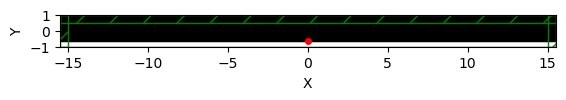

In [204]:
sim_fitting_Al.plot2D()

     block, center = (0,-0.85,0)
          size (1e+20,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)


<Axes: xlabel='X', ylabel='Y'>

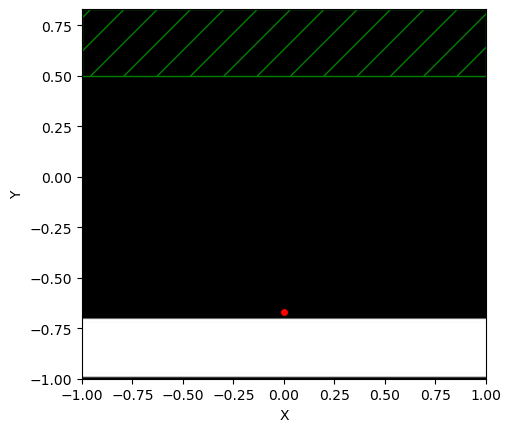

In [205]:
sim_fitting_Al.plot2D(output_plane = mp.Volume(center=mp.Vector3(0, -0.67, 0), size=mp.Vector3(2, 3, 0)))

In [196]:
offset = 0.01
flux_size = 0.02

# Dipole 위치
source_center = mp.Vector3(0, -0.67,0)

focus_lambda_min = 0.4
focus_lambda_max = 0.7

focus_f_min = 1/focus_lambda_max
focus_f_max = 1/focus_lambda_min

fcen_monitor = 0.5 * (focus_f_min + focus_f_max)
df_monitor = focus_f_max - focus_f_min

box_power_fitting_Al = sim_fitting_Al.add_flux(
    fcen_monitor, df_monitor, nfreq,
    mp.FluxRegion(center=source_center - mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size),
                  # direction=mp.X, 
                  weight=-1),
    mp.FluxRegion(center=source_center + mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size),
                  # direction=mp.X
                ),
    mp.FluxRegion(center=source_center - mp.Vector3(0, offset, 0),
                  size=mp.Vector3(flux_size, 0),
                  # direction=mp.Y, 
                  weight=-1),
    mp.FluxRegion(center=source_center + mp.Vector3(0, offset, 0),
                  size=mp.Vector3(flux_size, 0),
                  # direction=mp.Y
                  )
)

# sim_fitting_Al.run(until_after_sources = mp.stop_when_fields_decayed(1e-5, mp.Ex, source_center, 0), until = 200)

sim_fitting_Al.run(until = 10)
net_power_fitting_al = mp.get_fluxes(box_power_fitting_Al)

-----------
Initializing structure...
time for choose_chunkdivision = 0.00121284 s
Working in 2D dimensions.
Computational cell is 31 x 2 x 0 with resolution 400
     block, center = (0,-0.85,0)
          size (1e+20,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 6.17872 s
lorentzian susceptibility: frequency=11.0827, gamma=0
lorentzian susceptibility: frequency=9.29089, gamma=0
lorentzian susceptibility: frequency=2.63917, gamma=0.239163
lorentzian susceptibility: frequency=4.88478, gamma=0.020474
drude susceptibility: frequency=1, gamma=0
lorentzian susceptibility: frequency=1.04068, gamma=0.878562
-----------
Meep progress: 0.0375/10.0 = 0.4% done in 4.1s, 1092.6s to go
on time step 30 (time=0.0375), 0.137089 s/step
Meep progress: 0.08125/10.0 = 0.8% done in 8.2s, 996.4s to go
on time step 65 (time=0.08125), 0.115676 s/step
Meep progress: 0.125/10.0 = 1.2% done in 12.2s, 962.8s to go
on time step 

KeyboardInterrupt: 

In [209]:
import os
import imageio

# 저장할 디렉토리
output_dir = "frames_fitting_Al"
os.makedirs(output_dir, exist_ok=True)

# 시뮬레이션 준비
sim_fitting_Al.reset_meep()

# 몇 스텝마다 스냅샷을 저장할지 설정
snapshot_interval = 0.1  # 10 스텝마다 저장
total_steps = 20  # 총 시뮬레이션 스텝 수 (조정 가능)

def save_frame(sim):
    # 1. 필드 데이터 가져오기
    ex = sim.get_array(center=mp.Vector3(), size=sim.cell_size, component=mp.Ex)
    ey = sim.get_array(center=mp.Vector3(), size=sim.cell_size, component=mp.Ey)
    ez = sim.get_array(center=mp.Vector3(), size=sim.cell_size, component=mp.Ez)

    # 2. Electric Field Intensity 계산: |E|^2 = |Ex|^2 + |Ey|^2 + |Ez|^2
    intensity = np.abs(ex)**2 + np.abs(ey)**2 + np.abs(ez)**2

    # 3. 플롯 (감마 조정 없이, 정규화 없이 그대로)
    plt.figure(figsize=(8, 2))
    plt.imshow(intensity.T,
               interpolation='spline36',
               cmap='inferno',    # 여전히 대비가 좋은 컬러맵 (원하면 바꿀 수 있음)
               origin='lower',
               extent=[-cell_size.x/2, cell_size.x/2, -cell_size.y/2, cell_size.y/2])
    plt.colorbar(label=r'$|\mathbf{E}|^2$ (Intensity)')
    plt.title(f"Time step: {sim.round_time()}")
    plt.xlabel('x (μm)')
    plt.ylabel('y (μm)')
    plt.tight_layout()

    # 4. 이미지 저장
    filename = os.path.join(output_dir, f"frame_{sim.round_time():06.2f}.png")
    plt.savefig(filename)
    plt.close()

# 메인 러너
sim_fitting_Al.run(mp.at_every(snapshot_interval, save_frame), until=total_steps)

# 저장된 이미지 불러오기
filenames = sorted([os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith(".png")])

mp4_filename = "field_animation_fitting_Al.mp4"
with imageio.get_writer(mp4_filename, fps=10) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
print(f"MP4 생성 완료: {mp4_filename}")

-----------
Initializing structure...
time for choose_chunkdivision = 0.000468969 s
Working in 2D dimensions.
Computational cell is 31 x 2 x 0 with resolution 100
     block, center = (0,-0.85,0)
          size (1e+20,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.406817 s
lorentzian susceptibility: frequency=11.0827, gamma=0
lorentzian susceptibility: frequency=9.29089, gamma=0
lorentzian susceptibility: frequency=2.63917, gamma=0.239163
lorentzian susceptibility: frequency=4.88478, gamma=0.020474
drude susceptibility: frequency=1, gamma=0
lorentzian susceptibility: frequency=1.04068, gamma=0.878562
-----------
Meep progress: 0.9/20.0 = 4.5% done in 4.0s, 85.4s to go
on time step 180 (time=0.9), 0.0223622 s/step
Meep progress: 1.885/20.0 = 9.4% done in 8.0s, 77.2s to go
on time step 377 (time=1.885), 0.0203219 s/step
Meep progress: 2.6750000000000003/20.0 = 13.4% done in 12.0s, 77.9s to go
on time

/tmp/ipykernel_2257/2960560692.py:51: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (800, 200) to (800, 208) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


run 0 finished at t = 20.0 (4000 timesteps)
MP4 생성 완료: field_animation_fitting_Al.mp4


### resolution 1000 - air(sourcepower)

In [ ]:
from src_resolution import sourcepower

src_wavelengths, src_power = sourcepower(400)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000215054 s
Working in 2D dimensions.
Computational cell is 3 x 3 x 0 with resolution 100
time for set_epsilon = 0.048455 s
-----------
run 0 finished at t = 50.0 (10000 timesteps)
CSV 파일 저장 완료: sourcepower_res100.csv


In [157]:
import numpy as np
from pathlib import Path

csv_path = Path("/home/m2ni/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/RESOLUTION/Only_Al.csv")

# CSV 파일 불러오기
lumerical_data = np.genfromtxt(csv_path, delimiter=",")

lumerical = lumerical_data[:, 1]

In [158]:
# lumerical data import
import numpy as np
from pathlib import Path

csv_path = Path("/home/m2ni/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/sourcepower_1000.csv")

# CSV 파일 불러오기
air_1000_data = np.genfromtxt(csv_path, delimiter=",", skip_header=1)

air_1000 = air_1000_data[:, 1]

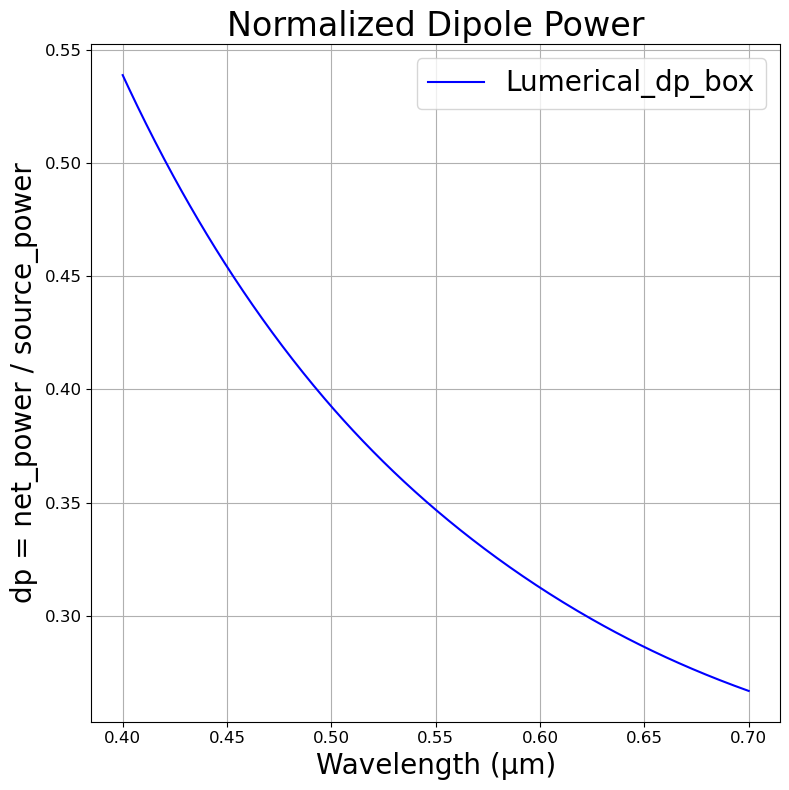

In [175]:
# dp_box / sourcepower 정규화
dp_fitting_al = np.array(net_power_fitting_al) / src_power

wavelengths = 1 / np.array(mp.get_flux_freqs(box_power_fitting_Al))

plt.figure(figsize=(8, 8))

# plot 순서
# plt.plot(wavelengths, dp_fitting_al, label='Meep_dp_box', color='red')
plt.plot(wavelengths, lumerical, label='Lumerical_dp_box', color='blue')
# plt.plot(wavelength_sliced_al_nofunc, Al_power_sliced_nofunc, label='Lumerical dp', color='green')


# 축 레이블 (굵게 + 크기 조정)
plt.xlabel("Wavelength (μm)", fontsize=20)
plt.ylabel("dp = net_power / source_power", fontsize=20)

# 제목 (굵게 + 크기 조정)
plt.title("Normalized Dipole Power", fontsize=24)

# 눈금 폰트 크기 조정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 범례 (폰트 크기 조정 + 굵게)
plt.legend(fontsize=20, frameon=True,)

# 기타 설정
plt.grid(True)
plt.tight_layout()
# plt.ylim([0, 1.5])
# plt.xlim([0.4, 0.7])
plt.show()

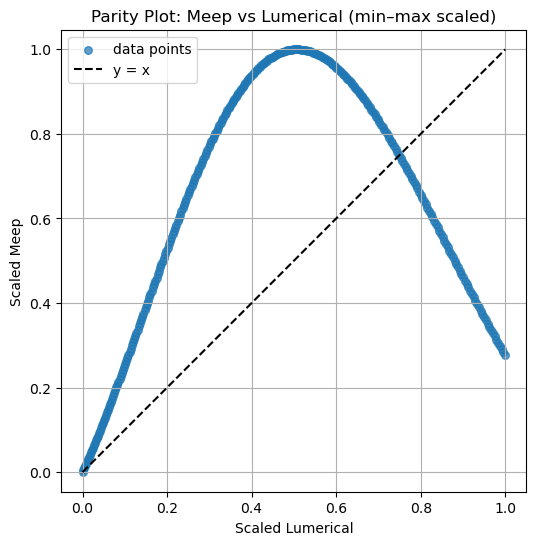

Pearson correlation coefficient (scaled): 0.3766


In [179]:
import numpy as np
import matplotlib.pyplot as plt

# -- 예시 데이터 로드 --
# wl : 파장 배열 (μm)
# dp_meep : Meep 피팅 결과 (normalized dipole power)
# dp_lum  : Lumerical 결과 (normalized dipole power)

# 1) min–max 스케일링 함수
def min_max_scale(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

dp_meep_s = min_max_scale(net_power_fitting_al)
dp_lum_s  = min_max_scale(lumerical)

# 2) 파리티 플롯
plt.figure(figsize=(6,6))
plt.scatter(dp_lum_s, dp_meep_s, s=30, alpha=0.7, label='data points')
plt.plot([0,1], [0,1], 'k--', label='y = x')
plt.xlabel('Scaled Lumerical')
plt.ylabel('Scaled Meep')
plt.title('Parity Plot: Meep vs Lumerical (min–max scaled)')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

# 3) 상관계수 계산
corr_coeff = np.corrcoef(dp_lum_s, dp_meep_s)[0,1]
print(f"Pearson correlation coefficient (scaled): {corr_coeff:.4f}")


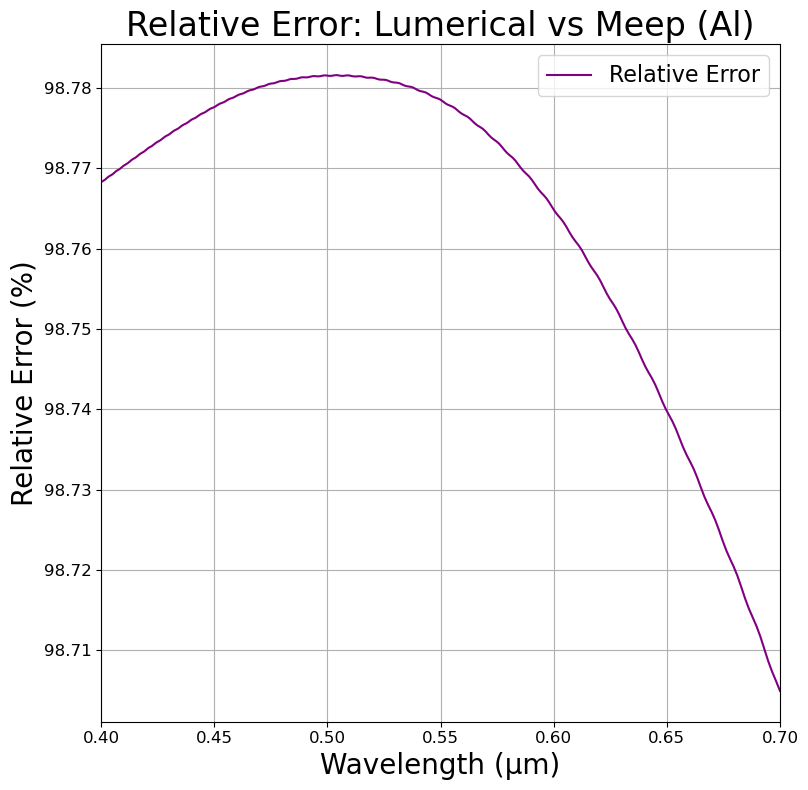

In [164]:
# === Relative Error 계산 === #
relative_error = np.abs((dp_fitting_al - lumerical) / lumerical)* 100

# relative_error_nofunc = np.abs((Al_power_sliced_nofunc - dp_fitting_al) / dp_fitting_al)* 100


# === Relative Error 플롯 === #
plt.figure(figsize=(8, 8))
plt.plot(wavelengths, relative_error, label='Relative Error', color='purple')
# plt.plot(wavelengths, relative_error_nofunc, label='Relative Error dp_box', color='cyan')


# 축 레이블
plt.xlabel("Wavelength (μm)", fontsize=20)
plt.ylabel("Relative Error (%)", fontsize=20)

# 제목
plt.title("Relative Error: Lumerical vs Meep (Al)", fontsize=24)

# 눈금, 범례
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.xlim([0.4, 0.7])
plt.show()
